Group Members : Girish Wangikar - 200475452
                Aniket Kekane - 200481347
        
                ECE 558 Project03 Final - Option 3 Blob Detection 

In [1]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
from PIL import Image

In [2]:
import numpy as np
from PIL import Image
#img = np.asarray(Image.open('butterfly.jpg').convert('L'))/255

"""Read input image and normalize the scale"""

def sub2ind(array_shape, rows, cols):
    ind = rows*array_shape[1] + cols
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    return ind

def ind2sub(array_shape, ind):
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    rows = (ind.astype('int') / array_shape[1])
    cols = ind % array_shape[1]
    return (rows, cols)

def Resizing(img, out_dims): 
    img_row = img.shape[0]
    img_col = img.shape[1]
    out_row = out_dims[0]
    out_col = out_dims[1]  
    S_R = img_row / out_row; 
    S_C = img_col / out_col;    
    cf, rf = np.meshgrid(np.linspace(1,out_col,out_col), np.linspace(1,out_row,out_row))
    rf = rf * S_R 
    cf = cf * S_C 
    r = np.floor(rf) 
    c = np.floor(cf)   
    r[r < 1] = 1
    c[c < 1] = 1
    r[r > img_row -1] = img_row -1
    c[c > img_col -1] = img_col -1    
    delta_R = rf - r
    delta_C = cf - c 
    in1_ind = r + (c-1) * img.shape[0]
    in2_ind = (r+1) + (c-1) * img.shape[0]
    in3_ind = r + (c) * img.shape[0]
    in4_ind = r+1 + (c) * img.shape[0]  
    temp = np.array(img.flatten(order='F')[in1_ind.astype(int)-1]) *(1 - delta_R) * (1 - delta_C) +\
    np.array(img.flatten(order='F')[in2_ind.astype(int)-1]) *(delta_R) * (1 - delta_C) +\
    np.array(img.flatten(order='F')[in3_ind.astype(int)-1]) *(1 - delta_R) * (delta_C) +\
    np.array(img.flatten(order='F')[in4_ind.astype(int)-1]) *(delta_R) * (delta_C)
    return temp

In [3]:
cd /Users/gsws/Desktop/ECE 558/Project03/TestImages4Project

/Users/gsws/Desktop/ECE 558/Project03/TestImages4Project


In [4]:
def padding(img):
    
    
    """Padding the image : Type of padding used -Zero Padding"""
    h=img.shape[0]
    w=img.shape[1]
      #padding value
      #minimum padding value must be 2
    pad_value = 8
    add = int(pad_value/2)
    new_array = np.zeros((h+pad_value,w+pad_value),dtype='float32')
    for i in range(0,h):
          for j in range(0,w):
            new_array[i+add,j+add] = img[i,j]
    return new_array

In [5]:
def conv(f,w):
    
    """Our Convolution Function from project 2"""
    current_matrix = np.array([[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]])
    x = padding(f)
    [s,t] = w.shape
    [a,b] = x.shape
    convoluted_img = np.zeros(shape=(a,b),dtype='float32')

    for i in range(0,a-s):
        for j in range(0,b-t):
            current_matrix = x[i:i+s,j:j+t] 
            convoluted_img[i,j] = (np.multiply(w,current_matrix)).sum()
            convoluted_img = convoluted_img.astype(np.float32)

    return convoluted_img

   

In [6]:
gaussian = (np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])) *  (1/9) # gassuan blurr filter for sub-sampling

# The Laplacian of Gaussian filter (LOG)
def Laplacian_of_gaussian_filter(sigma):
    n = int(2 * np.ceil(sigma * 2.5) + 1)    
    Log = np.zeros([n,n]) 
    for i in range(int(-np.floor(n/2)),int(np.floor(n/2))+1):
        for j in range(int(-np.floor(n/2)),int(np.floor(n/2))+1):
            Log[i + int(np.floor(n/2)), j +int(np.floor(n/2))] = \
            -(1/(np.pi * sigma ** 4)) * (1-((i**2 + j**2)/(2*sigma**2))) *\
            np.exp(-((i**2 + j**2)/(2*sigma**2))) * (sigma**2) # calculate each cell value based on LOG formula
    return Log
    

In [7]:
def non_max_suppression(array, n): 
    """Function to implement Non-Max Suppression"""
    rows = array.shape[0] 
    cols = array.shape[1]
    res_arr = np.zeros([rows, cols])
    for i in range(rows): 
        """Handling Boundary Conditions"""
        for j in range(cols):
            if i-(n-1)/2 < 0:
                a = 0
            else:
                a = int(i-(n-1)/2)  
            if j-(n-1)/2 < 0:  
                b = 0
            else: 
                b = int(j-(n-1)/2)
            if i+1+(n-1)/2 > rows:  
                a1 = int(rows)
            else:
                a1 = int(i+1+(n-1)/2)
            if (j+1+(n-1)/2) > cols:  
                b1 = int(cols)
            else:
                b1 = int(j+1+(n-1)/2)
            neighb = array[a:a1, b:b1]  
            res_arr[i, j] = np.max(neighb) 
    return res_arr

In [8]:
def create_scale_space(img, sigma, n, Filter = 'LOG'):
    
    """function to create scale space : n is number of scale wheras sigma is initial scale"""
    
    k=2**(0.35) #value of the scaling factor
    [org_row, org_col] = np.shape(img)
    scale_space = np.zeros([img.shape[0], img.shape[1], n]) 
    Scale_Space = np.zeros([img.shape[0], img.shape[1], n]) 
    for i in range(n):
        if Filter == 'LOG': 
            Log =Laplacian_of_gaussian_filter(sigma)
        else:
            Log = Dog_filter(sigma) 
        out_row = int(np.floor(org_row * 1/k**(i)))
        out_col = int(np.floor(org_col * 1/k**(i)))
        image_down = Resizing(img, [out_row, out_col])
        Log_filtered = conv(image_down, Log)
        Log_filtered = np.power(Log_filtered, 2) #squaring laplacian response
        scale_space[:,:,i] = Resizing(Log_filtered, [org_row, org_col])
        Scale_Space[:,:,i] = non_max_suppression(scale_space[:,:,i], 7)
        img = conv(img, gaussian)
    return scale_space, Scale_Space


In [9]:
def finding_scale(org_row, org_col, Scale_Space): 
    max_scale = np.zeros(Scale_Space.shape)
    for i in range(org_row): 
        for j in range(org_col):
           ind = np.unravel_index(np.argmax(Scale_Space[i,j,:]), Scale_Space[i,j,:].shape) 
           max_scale[i,j,ind[0]] =  Scale_Space[i,j,ind[0]] 
    return max_scale

In [10]:
def search_circles(max_scale, threshold, sigma):
    """Function to find circels and their radii"""
    radius = []
    coord = []
    k=2**(0.35) #scaling factor
    for i in range(max_scale.shape[2]): 
        ind = np.argwhere(max_scale[:,:,i] >= threshold)
        radius = np.ones([ind.shape[0],1]) * (2 ** 0.5 * sigma * k**(i)) # calculate radius based on scale 
        coord.append(np.concatenate((ind, radius), axis = 1)) 
    cc = np.zeros([1,3])
    for i in range(np.shape(coord)[0]):
        cc = np.concatenate((cc,coord[i]),axis = 0) 
    return cc[1:,:]



def create_circles(image, output_name, cx, cy, rad, color='r'):
    """Function to draw circles based on coordinates from find_circles function"""
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots() 
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray') 
    for x, y, r in zip(cx, cy, rad): 
        circ = Circle((x, y), r, color=color, fill=False, linewidth = 1.1) 
        ax.add_patch(circ) 
    plt.title('%i blobs found' % len(cx))
    out_name = output_name + '.png'
    plt.savefig(out_name) 
    plt.show()


In [11]:
def blob_detection(File_name, sigma, n, threshold, Filter = 'LOG', output_name = 'blob_out'):
    """blob detector function incorporating all above functions to give output image"""
    image = np.asarray(Image.open(File_name).convert('L'))/255 
    org_row, org_col = image.shape 
    start = time.time() 
    scale_space, Scale_Space = create_scale_space(image, sigma, n, Filter)
    max_scale = finding_scale(org_row, org_col, Scale_Space)
    max_scale = np.multiply(max_scale, (max_scale == scale_space)) 
    circles = search_circles(max_scale, threshold, sigma)
    create_circles(image, output_name, circles[:,1], circles[:,0], circles[:,2], color='r')
    end = time.time() 
    print('computation time = {:0.4f}'.format(end - start)) 


/Applications/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


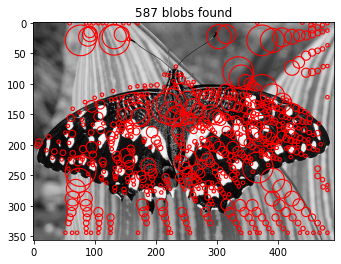

computation time = 85.5058


In [12]:
blob_detection('butterfly.jpg', 2, 10, 0.05, 'LOG', 'butterfly_blob_test')

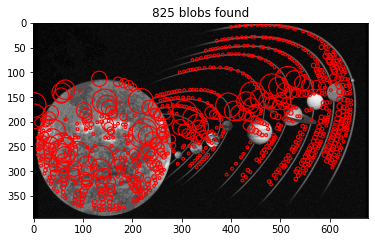

computation time = 172.8307


In [15]:
blob_detection('solar-system-1.jpg', 2, 10, 0.01, 'LOG', 'blob_test')